# LightGBM: Stratified Split Comparison (Titanic)

`00_prepare_data.ipynb` で作成した Titanic データで、
- 通常のランダム分割（非層化）
- stratified split（ラベル層化）
を比較します。

In [55]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [56]:
# 00_prepare_data.ipynb で保存したデータを読み込む
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full_common = train_df.drop(columns=['target'])
y_train_full_common = train_df['target'].astype(int)
X_test_common = test_df.drop(columns=['target'])
y_test_common = test_df['target'].astype(int)

print(f'X_train_full shape: {X_train_full_common.shape}')
print(f'X_test shape      : {X_test_common.shape}')
print('Train class ratio:', y_train_full_common.value_counts(normalize=True).sort_index().to_dict())
print('Test  class ratio:', y_test_common.value_counts(normalize=True).sort_index().to_dict())

X_train_full shape: (19536, 14)
X_test shape      : (29306, 14)
Train class ratio: {0: 0.7366400491400491, 1: 0.26335995085995084}
Test  class ratio: {0: 0.7366068381901317, 1: 0.26339316180986827}


In [57]:
# 分類タスクなので評価用ラベルを定義
class_labels = np.sort(y_train_full_common.unique())

In [58]:
# 01相当: 通常のランダム分割（Train/Validのみ、非層化）
X_train_base, X_valid_base, y_train_base, y_valid_base = train_test_split(
    X_train_full_common, y_train_full_common, test_size=0.25, random_state=SEED, stratify=None
)

# Baselineでも共通Testを利用
X_test_base = X_test_common
y_test_base = y_test_common

print('Baseline split sizes (with common test):')
print(f"Train: {X_train_base.shape}, Valid: {X_valid_base.shape}, Test: {X_test_base.shape}")
print('Base Train class ratio:', y_train_base.value_counts(normalize=True).sort_index().to_dict())
print('Base Valid class ratio:', y_valid_base.value_counts(normalize=True).sort_index().to_dict())
print('Base Test  class ratio:', y_test_base.value_counts(normalize=True).sort_index().to_dict())

Baseline split sizes (with common test):
Train: (14652, 14), Valid: (4884, 14), Test: (29306, 14)
Base Train class ratio: {0: 0.7346437346437347, 1: 0.26535626535626533}
Base Valid class ratio: {0: 0.7426289926289926, 1: 0.2573710073710074}
Base Test  class ratio: {0: 0.7366068381901317, 1: 0.26339316180986827}


In [59]:
# Stratified split: 共通TrainFullをラベル層化してTrain/Valid分割
X_train_strat, X_valid_strat, y_train_strat, y_valid_strat = train_test_split(
    X_train_full_common, y_train_full_common,
    test_size=0.25, random_state=SEED, stratify=y_train_full_common
)

# Stratifiedでも共通Testを利用
X_test_strat = X_test_common
y_test_strat = y_test_common

print('Stratified split sizes (with common test):')
print(f"Train: {X_train_strat.shape}, Valid: {X_valid_strat.shape}, Test: {X_test_strat.shape}")
print('Strat Train class ratio:', y_train_strat.value_counts(normalize=True).sort_index().to_dict())
print('Strat Valid class ratio:', y_valid_strat.value_counts(normalize=True).sort_index().to_dict())
print('Strat Test  class ratio:', y_test_strat.value_counts(normalize=True).sort_index().to_dict())
print(f"Same test index as baseline: {X_test_base.index.equals(X_test_strat.index)}")

Stratified split sizes (with common test):
Train: (14652, 14), Valid: (4884, 14), Test: (29306, 14)
Strat Train class ratio: {0: 0.7366229866229866, 1: 0.26337701337701336}
Strat Valid class ratio: {0: 0.7366912366912367, 1: 0.2633087633087633}
Strat Test  class ratio: {0: 0.7366068381901317, 1: 0.26339316180986827}
Same test index as baseline: True


In [60]:
def train_and_evaluate(method_name, X_train, y_train, X_valid, y_valid, X_test, y_test):
    model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(class_labels),
        n_estimators=120,
        learning_rate=0.05,
        num_leaves=7,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        bagging_seed=SEED,
        feature_fraction_seed=SEED,
        data_random_seed=SEED,
        deterministic=True,
        force_col_wise=True
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='multi_logloss'
    )

    proba_train = model.predict_proba(X_train)
    proba_valid = model.predict_proba(X_valid)
    proba_test = model.predict_proba(X_test)

    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    pred_test = model.predict(X_test)

    metrics = pd.DataFrame({
        'Method': [method_name, method_name, method_name],
        'Split': ['Train', 'Valid', 'Test'],
        'Accuracy': [
            accuracy_score(y_train, pred_train),
            accuracy_score(y_valid, pred_valid),
            accuracy_score(y_test, pred_test),
        ],
        'F1_macro': [
            f1_score(y_train, pred_train, average='macro'),
            f1_score(y_valid, pred_valid, average='macro'),
            f1_score(y_test, pred_test, average='macro'),
        ],
        'LogLoss': [
            log_loss(y_train, proba_train, labels=class_labels),
            log_loss(y_valid, proba_valid, labels=class_labels),
            log_loss(y_test, proba_test, labels=class_labels),
        ]
    })
    return model, metrics

In [61]:
_, metrics_base = train_and_evaluate(
    'Baseline(01-like)',
    X_train_base, y_train_base, X_valid_base, y_valid_base, X_test_base, y_test_base
)

_, metrics_strat = train_and_evaluate(
    'Stratified(02)',
    X_train_strat, y_train_strat, X_valid_strat, y_valid_strat, X_test_strat, y_test_strat
)

metrics_compare = pd.concat([metrics_base, metrics_strat], ignore_index=True)
display(metrics_compare)

[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 14652, number of used features: 14
[LightGBM] [Info] Start training from score -0.308370
[LightGBM] [Info] Start training from score -1.326682
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 14652, number of used features: 14
[LightGBM] [Info] Start training from score -0.305679
[LightGBM] [Info] Start training from score -1.334169


,Method,Split,Accuracy,F1_macro,LogLoss
0,Baseline(01-like),Train,0.827396,0.749928,0.370274
1,Baseline(01-like),Valid,0.826577,0.742301,0.374769
2,Baseline(01-like),Test,0.826657,0.747900,0.377411
3,Stratified(02),Train,0.828829,0.751649,0.369297
4,Stratified(02),Valid,0.824939,0.745470,0.375360
5,Stratified(02),Test,0.827134,0.749977,0.378008


In [62]:
# 比較テーブル（Splitごと）
pivot_acc = metrics_compare.pivot(index='Split', columns='Method', values='Accuracy')
pivot_f1 = metrics_compare.pivot(index='Split', columns='Method', values='F1_macro')
pivot_logloss = metrics_compare.pivot(index='Split', columns='Method', values='LogLoss')

improvement = pd.DataFrame({
    'Accuracy diff (Stratified - Baseline)': pivot_acc['Stratified(02)'] - pivot_acc['Baseline(01-like)'],
    'F1 diff (Stratified - Baseline)': pivot_f1['Stratified(02)'] - pivot_f1['Baseline(01-like)'],
    'LogLoss diff (Stratified - Baseline)': pivot_logloss['Stratified(02)'] - pivot_logloss['Baseline(01-like)']
})

print('Accuracy comparison')
display(pivot_acc)
print('F1_macro comparison')
display(pivot_f1)
print('LogLoss comparison')
display(pivot_logloss)
print('Difference (Stratified - Baseline)')
display(improvement)

Accuracy comparison


Method,Baseline(01-like),Stratified(02)
Split,,
Test,0.826657,0.827134
Train,0.827396,0.828829
Valid,0.826577,0.824939


F1_macro comparison


Method,Baseline(01-like),Stratified(02)
Split,,
Test,0.747900,0.749977
Train,0.749928,0.751649
Valid,0.742301,0.745470


LogLoss comparison


Method,Baseline(01-like),Stratified(02)
Split,,
Test,0.377411,0.378008
Train,0.370274,0.369297
Valid,0.374769,0.375360


Difference (Stratified - Baseline)


,Accuracy diff (Stratified - Baseline),F1 diff (Stratified - Baseline),LogLoss diff (Stratified - Baseline)
Split,,,
Test,0.000478,0.002078,0.000597
Train,0.001433,0.001721,-0.000977
Valid,-0.001638,0.003170,0.000590


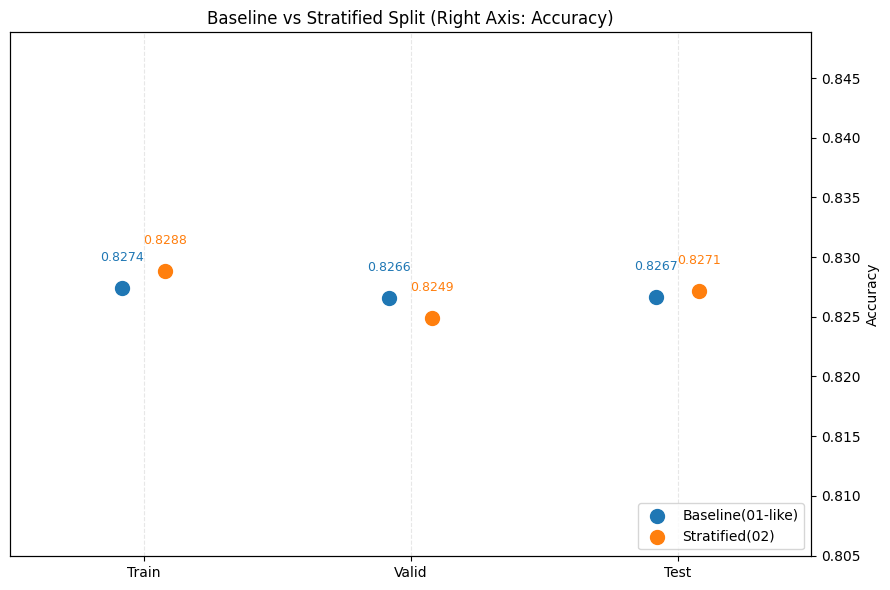

In [63]:
# 右軸にAccuracyを置いた散布図で比較（最終評価）
fig, ax = plt.subplots(figsize=(9, 6))
ax_right = ax.twinx()

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_base = [pivot_acc.loc[s, 'Baseline(01-like)'] for s in split_order]
acc_strat = [pivot_acc.loc[s, 'Stratified(02)'] for s in split_order]

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_base, s=100, label='Baseline(01-like)', color='tab:blue')
ax_right.scatter(x + offset, acc_strat, s=100, label='Stratified(02)', color='tab:orange')

for i, v in enumerate(acc_base):
    ax_right.text(x[i] - offset, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, v in enumerate(acc_strat):
    ax_right.text(x[i] + offset, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

all_acc = np.array(acc_base + acc_strat)
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.set_ylabel('Accuracy')
ax_right.legend(loc='lower right')

plt.title('Baseline vs Stratified Split (Right Axis: Accuracy)')
plt.tight_layout()
plt.show()